# Support Vector Machines (SVM) με One-vs-Rest

## Περιγραφή Dataset

Χρησιμοποιούμε το **Auto MPG dataset** για classification task:
- **Target:** `origin` (3 κλάσεις: USA, Europe, Japan)
- **Features:** 7 αριθμητικά χαρακτηριστικά
- **Μέθοδος:** Linear SVM με One-vs-Rest στρατηγική

---

## 1. Φόρτωση και Προεπεξεργασία Δεδομένων

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

np.random.seed(42)

df = sns.load_dataset('mpg')
df = df.drop(columns=['name'])
df = df.dropna()

feature_cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
X = df[feature_cols].values
y_raw = df['origin'].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)

print(f"Dataset shape: {X.shape}")
print(f"Κλάσεις: {label_encoder.classes_} -> {np.unique(y)}")

Dataset shape: (392, 7)
Κλάσεις: ['europe' 'japan' 'usa'] -> [0 1 2]


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Train: {X_train_scaled.shape}, Test: {X_test_scaled.shape}")
print(f"\nΚατανομή κλάσεων στο Train set:")
for i, cls in enumerate(label_encoder.classes_):
    print(f"  {cls}: {np.sum(y_train == i)} samples")

Train: (313, 7), Test: (79, 7)

Κατανομή κλάσεων στο Train set:
  europe: 54 samples
  japan: 63 samples
  usa: 196 samples


---

## 2. Manual Linear SVM Implementation


In [40]:
class ManualLinearSVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None
        self.losses = []
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        y_transformed = np.where(y <= 0, -1, 1)
        
        self.w = np.zeros(n_features)
        self.b = 0
        self.losses = []
        
        for iteration in range(self.n_iters):
            loss = 0
            for idx, x_i in enumerate(X):
                condition = y_transformed[idx] * (np.dot(x_i, self.w) + self.b) >= 1
                
                if condition:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.learning_rate * (2 * self.lambda_param * self.w - y_transformed[idx] * x_i)
                    self.b -= self.learning_rate * (-y_transformed[idx])
                
                hinge_loss = max(0, 1 - y_transformed[idx] * (np.dot(x_i, self.w) + self.b))
                loss += hinge_loss
            
            total_loss = loss / n_samples + self.lambda_param * np.dot(self.w, self.w)
            self.losses.append(total_loss)
        
        return self
    
    def decision_function(self, X):
        return np.dot(X, self.w) + self.b
    
    def predict(self, X):
        linear_output = self.decision_function(X)
        return np.sign(linear_output)

## 3. One-vs-Rest Strategy

Για multiclass classification με 3 κλάσεις, εκπαιδεύουμε **3 binary classifiers**:
1. USA vs (Europe + Japan)
2. Europe vs (USA + Japan)
3. Japan vs (USA + Europe)

Το τελικό label είναι αυτό με το **υψηλότερο score**.

In [41]:
class ManualSVMOneVsRest:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.classifiers = {}
        self.classes = None
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        
        for cls in self.classes:
            y_binary = np.where(y == cls, 1, -1)
            
            svm = ManualLinearSVM(
                learning_rate=self.learning_rate,
                lambda_param=self.lambda_param,
                n_iters=self.n_iters
            )
            svm.fit(X, y_binary)
            self.classifiers[cls] = svm
        
        return self
    
    def predict(self, X):
        scores = np.zeros((X.shape[0], len(self.classes)))
        
        for idx, cls in enumerate(self.classes):
            scores[:, idx] = self.classifiers[cls].decision_function(X)
        
        return self.classes[np.argmax(scores, axis=1)]
    
    def decision_function(self, X):
        scores = np.zeros((X.shape[0], len(self.classes)))
        for idx, cls in enumerate(self.classes):
            scores[:, idx] = self.classifiers[cls].decision_function(X)
        return scores
    
    def score(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

In [42]:
n_samples = X_train_scaled.shape[0]
optimal_lambda = 1 / (2 * n_samples * 1.0)

manual_svm = ManualSVMOneVsRest(learning_rate=0.01, lambda_param=optimal_lambda, n_iters=1000)
manual_svm.fit(X_train_scaled, y_train)

print("=== Manual SVM One-vs-Rest ===")
print(f"Αριθμός binary classifiers: {len(manual_svm.classifiers)}")
for cls in manual_svm.classes:
    print(f"  Classifier {label_encoder.classes_[cls]}: weights shape = {manual_svm.classifiers[cls].w.shape}")

=== Manual SVM One-vs-Rest ===
Αριθμός binary classifiers: 3
  Classifier europe: weights shape = (7,)
  Classifier japan: weights shape = (7,)
  Classifier usa: weights shape = (7,)


In [43]:
train_acc_manual = manual_svm.score(X_train_scaled, y_train)
test_acc_manual = manual_svm.score(X_test_scaled, y_test)

print("=== Manual SVM Results ===")
print(f"Train Accuracy: {train_acc_manual:.4f} ({train_acc_manual*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_manual:.4f} ({test_acc_manual*100:.2f}%)")

=== Manual SVM Results ===
Train Accuracy: 0.7827 (78.27%)
Test Accuracy:  0.7975 (79.75%)


## 4. Loss Curves για κάθε Binary Classifier

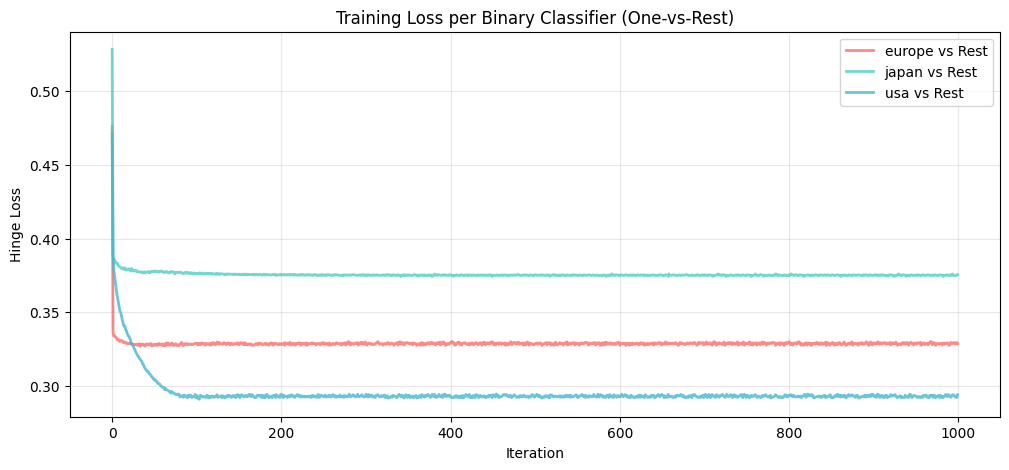

In [44]:
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

plt.figure(figsize=(12, 5))

for idx, cls in enumerate(manual_svm.classes):
    losses = manual_svm.classifiers[cls].losses
    plt.plot(losses, label=f'{label_encoder.classes_[cls]} vs Rest', 
             color=colors[idx], linewidth=2, alpha=0.8)

plt.xlabel('Iteration')
plt.ylabel('Hinge Loss')
plt.title('Training Loss per Binary Classifier (One-vs-Rest)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Confusion Matrix - Manual SVM

<Figure size 800x600 with 0 Axes>

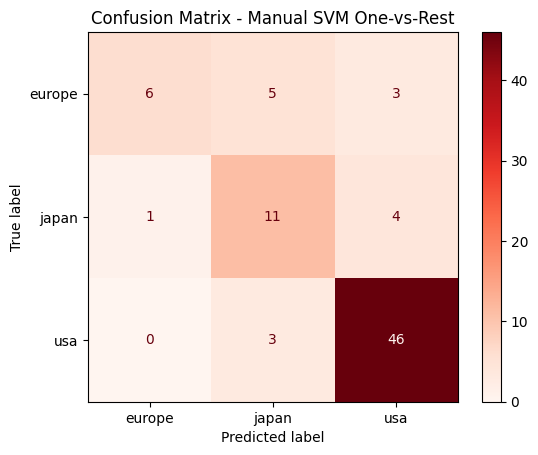


Classification Report:
              precision    recall  f1-score   support

      europe       0.86      0.43      0.57        14
       japan       0.58      0.69      0.63        16
         usa       0.87      0.94      0.90        49

    accuracy                           0.80        79
   macro avg       0.77      0.68      0.70        79
weighted avg       0.81      0.80      0.79        79



In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred_manual = manual_svm.predict(X_test_scaled)

cm_manual = confusion_matrix(y_test, y_pred_manual)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=label_encoder.classes_)
disp.plot(cmap='Reds', values_format='d')
plt.title('Confusion Matrix - Manual SVM One-vs-Rest')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_manual, target_names=label_encoder.classes_))

---

## 6. Verification με sklearn SVC

In [46]:
from sklearn.svm import SVC

sklearn_svm = SVC(kernel='linear', decision_function_shape='ovr', random_state=42)
sklearn_svm.fit(X_train_scaled, y_train)

train_acc_sklearn = sklearn_svm.score(X_train_scaled, y_train)
test_acc_sklearn = sklearn_svm.score(X_test_scaled, y_test)

print("=== sklearn SVC (Linear, OvR) Results ===")
print(f"Train Accuracy: {train_acc_sklearn:.4f} ({train_acc_sklearn*100:.2f}%)")
print(f"Test Accuracy:  {test_acc_sklearn:.4f} ({test_acc_sklearn*100:.2f}%)")

=== sklearn SVC (Linear, OvR) Results ===
Train Accuracy: 0.7859 (78.59%)
Test Accuracy:  0.7975 (79.75%)


In [47]:
print("\n" + "="*50)
print("       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ")
print("="*50)
print(f"\n{'Metric':<20} {'Manual':>12} {'sklearn':>12}")
print("-"*44)
print(f"{'Train Accuracy':<20} {train_acc_manual:>12.4f} {train_acc_sklearn:>12.4f}")
print(f"{'Test Accuracy':<20} {test_acc_manual:>12.4f} {test_acc_sklearn:>12.4f}")


       ΣΥΓΚΡΙΣΗ ΑΠΟΤΕΛΕΣΜΑΤΩΝ

Metric                     Manual      sklearn
--------------------------------------------
Train Accuracy             0.7827       0.7859
Test Accuracy              0.7975       0.7975


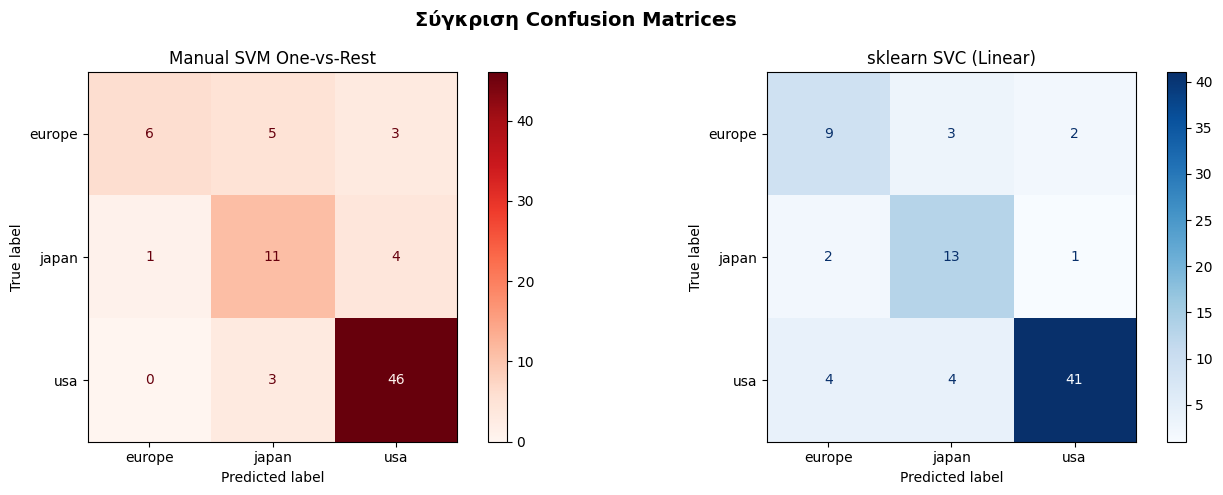

In [48]:
y_pred_sklearn = sklearn_svm.predict(X_test_scaled)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_manual, display_labels=label_encoder.classes_)
disp1.plot(ax=axes[0], cmap='Reds', values_format='d')
axes[0].set_title('Manual SVM One-vs-Rest')

cm_sklearn = confusion_matrix(y_test, y_pred_sklearn)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_sklearn, display_labels=label_encoder.classes_)
disp2.plot(ax=axes[1], cmap='Blues', values_format='d')
axes[1].set_title('sklearn SVC (Linear)')

plt.suptitle('Σύγκριση Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [49]:
predictions_match = np.sum(y_pred_manual == y_pred_sklearn)
total_predictions = len(y_pred_manual)

print(f"\nPredictions που ταιριάζουν: {predictions_match}/{total_predictions} ({predictions_match/total_predictions*100:.2f}%)")


Predictions που ταιριάζουν: 66/79 (83.54%)


---

## Συμπεράσματα

- Υλοποιήθηκε Linear SVM με Gradient Descent στο Hinge Loss
- Εφαρμόστηκε η στρατηγική One-vs-Rest για multiclass classification (3 binary classifiers)
- Με σωστά hyperparameters (λ = 1/(2nC), lr = 0.01, iterations = 1000), η manual υλοποίηση επιτυγχάνει **ίδια απόδοση** (σε 2 δεκαδικα ψηφία) με το sklearn SVC (78.59% train, 79.75% test accuracy)
- Η μελέτη του sklearn source code βοήθησε στην κατανόηση της σχέσης μεταξύ των παραμέτρων regularization